# Convolutional Autoencoder Training for Anomaly Detection @ L1Trigger

# Packages

In [1]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, auc
import tensorflow_probability as tfp

import keras_tuner
from keras_tuner import Hyperband

import joblib

# Input files reading

All input files are already sorted in Calo regions (i, j) ~ (18, 14)<br>
Where i = 0 -> 17 corresponds to GCT_Phi = 0 -> 17<br>
Where j = 0 -> 13 corresponds to RCT_Eta = 4 -> 17

Keep this ordering as is when feeding into neural nets. Also keep this in mind when generating/preparing new samples.

Zerobias and MC signal files:

In [2]:
'''
ZeroBiasA0 = h5py.File('bkg/ZeroBias2018RunA_0.h5', 'r')
ZeroBiasA1 = h5py.File('bkg/ZeroBias2018RunA_1.h5', 'r')
ZeroBiasA2 = h5py.File('bkg/ZeroBias2018RunA_2.h5', 'r')
ZeroBiasA0 = np.stack((ZeroBiasA0['CaloRegions'][:].astype('float32'),
                       (~ZeroBiasA0['ElectronBit'][:]+2).astype('float32'),
                       (~ZeroBiasA0['TauBit'][:]+2).astype('float32')))
ZeroBiasA1 = np.stack((ZeroBiasA1['CaloRegions'][:].astype('float32'),
                       (~ZeroBiasA1['ElectronBit'][:]+2).astype('float32'),
                       (~ZeroBiasA1['TauBit'][:]+2).astype('float32')))
ZeroBiasA2 = np.stack((ZeroBiasA2['CaloRegions'][:].astype('float32'),
                       (~ZeroBiasA2['ElectronBit'][:]+2).astype('float32'),
                       (~ZeroBiasA2['TauBit'][:]+2).astype('float32')))
ZeroBiasA0 = np.moveaxis(ZeroBiasA0, 0, -1)
ZeroBiasA1 = np.moveaxis(ZeroBiasA1, 0, -1)
ZeroBiasA2 = np.moveaxis(ZeroBiasA2, 0, -1)
ZeroBiasA = np.concatenate((ZeroBiasA0, ZeroBiasA1, ZeroBiasA2))
del ZeroBiasA0
del ZeroBiasA1
del ZeroBiasA2
'''

ZeroBias = h5py.File('bkg/EphemeralZeroBias2018RunD_1.h5', 'r')
ZeroBias = np.stack((ZeroBias['CaloRegions'][:500000].astype('float32'),
                     ZeroBias['EGBit'][:500000].astype('float32'),
                     ZeroBias['TauBit'][:500000].astype('float32')))
ZeroBias = np.moveaxis(ZeroBias, 0, -1)

print('ZeroBias shape: ' + str(ZeroBias.shape))

MC_files = []
MC_files.append('bkg/110X/QCD_Pt-15to7000_TuneCP5_Flat_14TeV_0.h5')#i=0
MC_files.append('bkg/120X/SingleNeutrino_E-10-gun_0.h5')#i=1
MC_files.append('bkg/120X/SingleNeutrino_Pt-2To20-gun_0.h5')#i=2
'''
MC_files.append('sig/110X/GluGluToHHTo4B_node_SM_TuneCP5_14TeV.h5')#i=3
MC_files.append('sig/110X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/VBFHToTauTau_M125_TuneCUETP8M1_14TeV.h5')
MC_files.append('sig/110X/VBF_HH_CV_1_C2V_1_C3_1_TuneCP5_PSweights_14TeV.h5')
MC_files.append('sig/110X/VBF_HToInvisible_M125_TuneCUETP8M1_14TeV.h5')
MC_files.append('sig/110X/VectorZPrimeToQQ_M100_pT300_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/VectorZPrimeToQQ_M200_pT300_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/VectorZPrimeToQQ_M50_pT300_TuneCP5_14TeV.h5')#i=13
MC_files.append('sig/110X/ZprimeToZH_MZprime1000_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/ZprimeToZH_MZprime600_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/ZprimeToZH_MZprime800_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
'''

MC_files.append('sig/120X/GluGluHToTauTau_M-125_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/GluGluToHHTo4B_node_cHHH1_TuneCP5_14TeV.h5')
'''
MC_files.append('sig/120X/GluGluToHHTo4B_node_cHHH5_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-100000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-12_CTau-9000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')#i=23
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-15000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-30000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-1000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-60_CTau-1000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-1000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-500mm_TuneCP5_14TeV.h5')#i=33
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-1000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-500mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-1200_TuneCP5_13TeV-pythia814TeV.h5')
MC_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-120_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-350_TuneCP5_14TeV.h5')#i=43
MC_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-600_TuneCP5_14TeV.h5')
'''
MC_files.append('sig/120X/TT_TuneCP5_14TeV.h5')
'''
MC_files.append('sig/120X/TprimeBToTH_M-650_LH_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VBFHHTo4B_CV_1_C2V_2_C3_1_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VBFHToInvisible_M125_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VBFHToTauTau_M125_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VectorZPrimeGammaToQQGamma_M-10_GPt-75_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VectorZPrimeToQQ_M-100_Pt-300_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VectorZPrimeToQQ_M-200_Pt-300_TuneCP5_14TeV.h5')#i=52
MC_files.append('sig/120X/emj-mMed-800-mDark-10-ctau-0p1.h5')
MC_files.append('sig/120X/emj-mMed-800-mDark-10-ctau-1.h5')
MC_files.append('sig/120X/emj-mMed-800-mDark-10-ctau-1000.h5')
MC_files.append('sig/120X/emj-mMed-800-mDark-10-ctau-150.h5')
'''
MC_files.append('sig/120X/haa4b_ma15_powheg.h5')
'''
MC_files.append('sig/120X/haa4b_ma15_powheg_FlatPU0To80.h5')
MC_files.append('sig/120X/haa4b_ma50_powheg.h5')
MC_files.append('sig/120X/haa4taus_ma15_powheg.h5')
'''

MC = []
for i in range(len(MC_files)):
    MC.append(h5py.File(MC_files[i], 'r'))
    MC[i] = np.stack((MC[i]['CaloRegions'][:500000].astype('float32'),
                      MC[i]['EGBit'][:500000].astype('float32'),
                      MC[i]['TauBit'][:500000].astype('float32')))
    MC[i] = np.moveaxis(MC[i], 0, -1)
    print('i = ' + str(i) + ': ' + str(MC[i].shape))

ZeroBias shape: (500000, 18, 14, 3)
i = 0: (500000, 18, 14, 3)
i = 1: (500000, 18, 14, 3)
i = 2: (500000, 18, 14, 3)
i = 3: (300000, 18, 14, 3)
i = 4: (100000, 18, 14, 3)
i = 5: (500000, 18, 14, 3)
i = 6: (98600, 18, 14, 3)


Visualize Et and EG/Tau bits per event

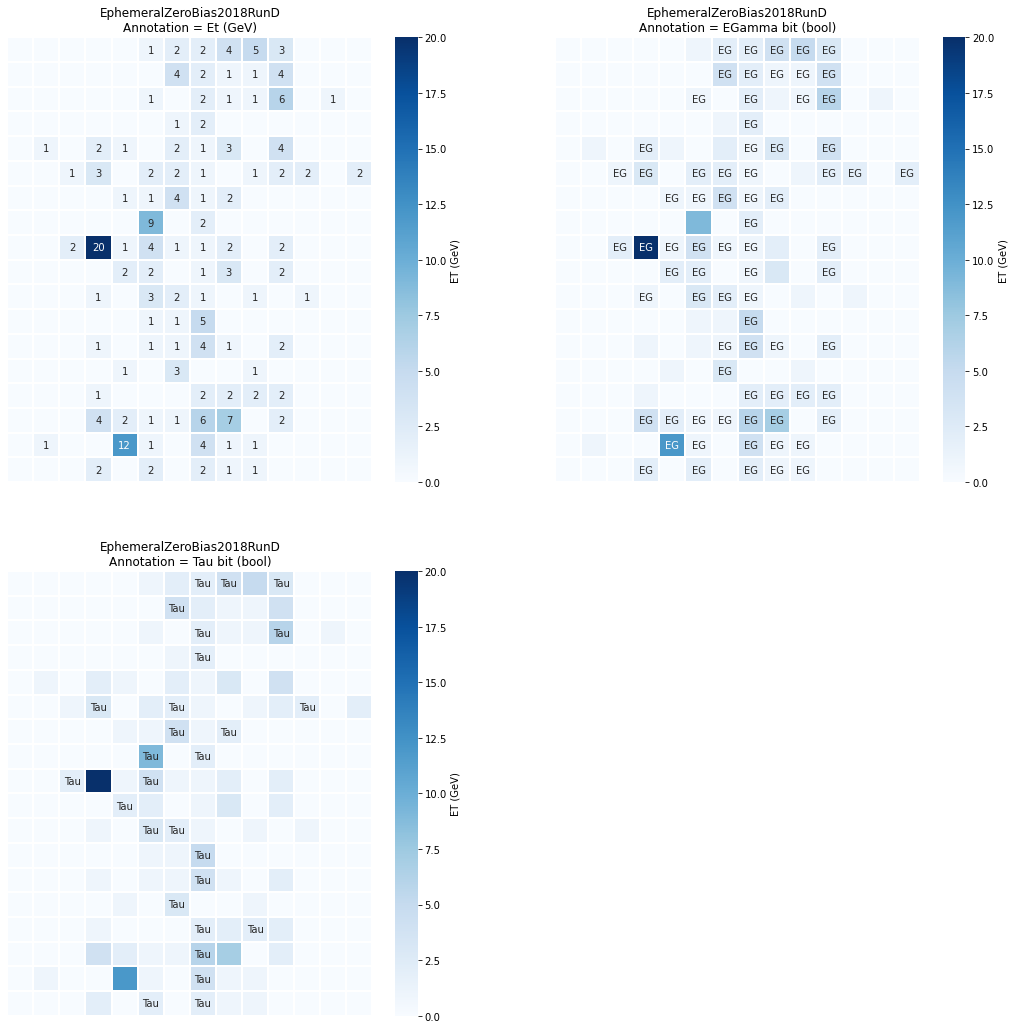

In [6]:
for n in range(1230,1231):
    bits = np.empty(shape = (18,14,3), dtype = 'object')
    for i in range(18):
        for j in range(14):
            if ZeroBias[n,i,j,0]==0:
                bits[i,j,0] = ' '
            if ZeroBias[n,i,j,0]>0:
                bits[i,j,0] = ZeroBias[n,i,j,0].astype(int)
            if ZeroBias[n,i,j,1]==0:
                bits[i,j,1] = ' '
            if ZeroBias[n,i,j,1]==1:
                bits[i,j,1] = 'EG'
            if ZeroBias[n,i,j,2]==0:
                bits[i,j,2] = ' '
            if ZeroBias[n,i,j,2]==1:
                bits[i,j,2] = 'Tau'
    
    fig, ax = plt.subplots(figsize = (18,18))
    ax = plt.subplot(2, 2, 1)
    ax = sns.heatmap(ZeroBias[n,:,:,0], vmin = 0, vmax = ZeroBias[n,:,:,0].max(), annot = bits[:,:,0], fmt = '', linewidths = 0.1, cmap = "Blues", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('EphemeralZeroBias2018RunD\nAnnotation = Et (GeV)')

    ax = plt.subplot(2, 2, 2)
    ax = sns.heatmap(ZeroBias[n,:,:,0], vmin = 0, vmax = ZeroBias[n,:,:,0].max(), annot = bits[:,:,1], fmt = '', linewidths = 0.1, cmap = "Blues", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('EphemeralZeroBias2018RunD\nAnnotation = EGamma bit (bool)')
    
    ax = plt.subplot(2, 2, 3)
    ax = sns.heatmap(ZeroBias[n,:,:,0], vmin = 0, vmax = ZeroBias[n,:,:,0].max(), annot = bits[:,:,2], fmt = '', linewidths = 0.1, cmap = "Blues", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('EphemeralZeroBias2018RunD\nAnnotation = Tau bit (bool)')
    
    plt.show()
    
del bits

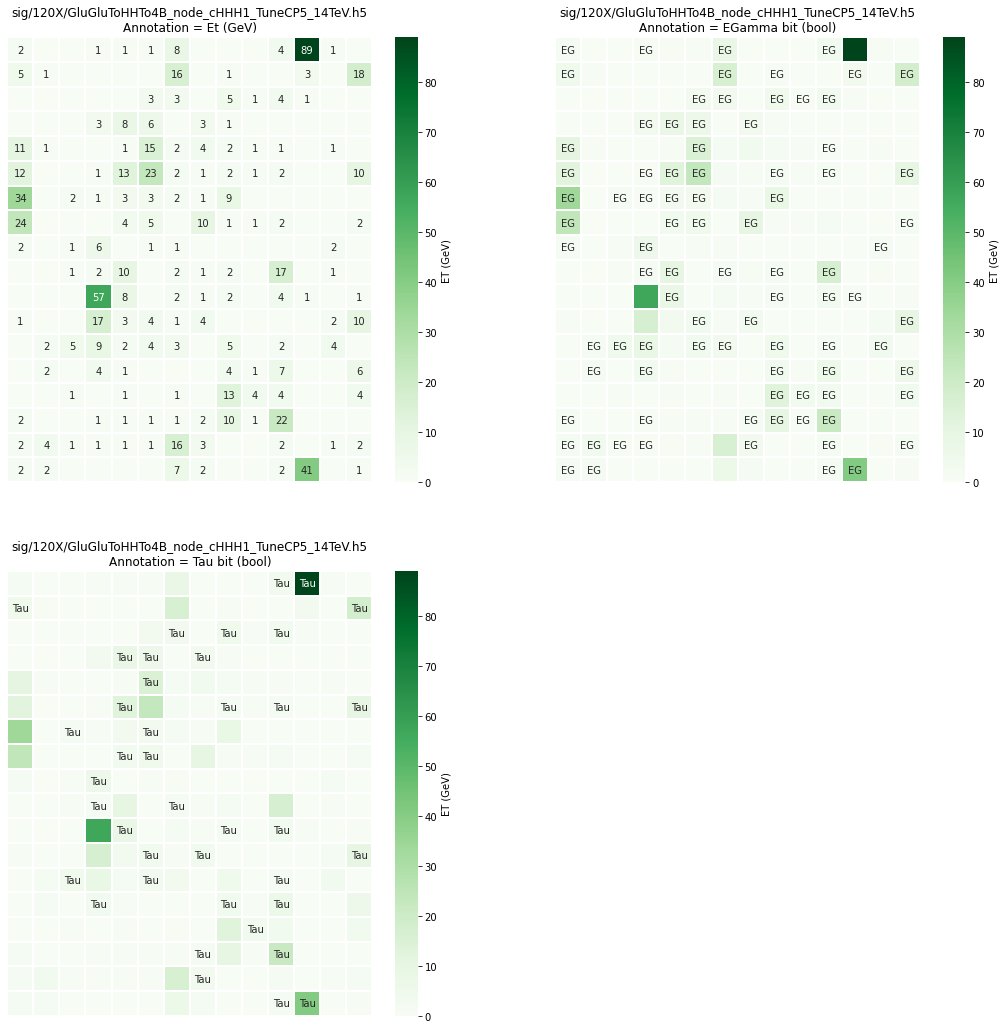

In [7]:
k=4
for n in range(193,194):
    bits = np.empty(shape = (18,14,3), dtype = 'object')
    for i in range(18):
        for j in range(14):
            if MC[k][n,i,j,0]==0:
                bits[i,j,0] = ' '
            if MC[k][n,i,j,0]>0:
                bits[i,j,0] = MC[k][n,i,j,0].astype(int)
            if MC[k][n,i,j,1]==0:
                bits[i,j,1] = ' '
            if MC[k][n,i,j,1]==1:
                bits[i,j,1] = 'EG'
            if MC[k][n,i,j,2]==0:
                bits[i,j,2] = ' '
            if MC[k][n,i,j,2]==1:
                bits[i,j,2] = 'Tau'

    fig, ax = plt.subplots(figsize = (18,18))
    ax = plt.subplot(2, 2, 1)
    ax = sns.heatmap(MC[k][n,:,:,0], vmin = 0, vmax = MC[k][n,:,:,0].max(), annot = bits[:,:,0], fmt = '', linewidths = 0.1, cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('{}\nAnnotation = Et (GeV)'.format(MC_files[k]))

    ax = plt.subplot(2, 2, 2)
    ax = sns.heatmap(MC[k][n,:,:,0], vmin = 0, vmax = MC[k][n,:,:,0].max(), annot = bits[:,:,1], fmt = '', linewidths = 0.1, cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('{}\nAnnotation = EGamma bit (bool)'.format(MC_files[k]))
    
    ax = plt.subplot(2, 2, 3)
    ax = sns.heatmap(MC[k][n,:,:,0], vmin = 0, vmax = MC[k][n,:,:,0].max(), annot = bits[:,:,2], fmt = '', linewidths = 0.1, cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('{}\nAnnotation = Tau bit (bool)'.format(MC_files[k]))
    
    plt.show()
    
del bits

Take a look at some ZB statistics.

In [ ]:
ZB_mean = np.mean(ZeroBias[:,:,:,0], axis = 0)

fig, ax = plt.subplots(figsize = (10,10))
ax = plt.subplot(2, 2, 2)
ax = sns.heatmap(ZB_mean.reshape(18, 14), vmin = 0, vmax = ZB_mean.max(), cmap = "Blues", cbar_kws = {'label': 'ET (GeV)'})
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Mean Et distribution (EphemeralZeroBias2018RunD)')
plt.show()

In [ ]:
plt.hist(ZeroBias[:,:,:,0].reshape((-1)), bins = 20, log = True)
plt.xlabel("ZeroBias Et")
plt.show()

print('Mean ZeroBias pT = ' + str(np.mean(ZeroBias.reshape(-1))))

# Conv AE

Convolutional autoencoder to be trained for input reconstruction (to be used as a teacher model for Knowledge Distillation later).

The encoder part, transforming the (18, 14) region input into a smaller latent space.

In [ ]:
encoder_input = tf.keras.Input(shape=(18,14,3), name='input')

encoder = layers.Conv2D(30, (3,3), strides=1, padding='same', name='conv2d_1')(encoder_input)
encoder = layers.Activation('relu', name='relu_1')(encoder)
encoder = layers.AveragePooling2D((2,2), name='pool_1')(encoder)
encoder = layers.Conv2D(40, (3,3), strides=1, padding='same', name='conv2d_2')(encoder)
encoder = layers.Activation('relu', name='relu_2')(encoder)
encoder = layers.Flatten(name='flatten')(encoder)

encoder_output = layers.Dense(120, activation='relu', name='latent')(encoder)

encoder = tf.keras.models.Model(encoder_input, encoder_output)
encoder.summary()

The decoder part, reconstructing from latent space back to the (18, 14) region input. Note the Conv2DTranspose is not yet supported in hls4ml, but ok to use if it is going to be distilled to another network. 

In [ ]:
decoder = layers.Dense(9*7*40, name='dense')(encoder_output)
decoder = layers.Reshape((9,7,40), name='reshape')(decoder)
decoder = layers.Activation('relu', name='relu_3')(decoder)
decoder = layers.Conv2D(40, (3,3), strides=1, padding='same', name='conv2d_3')(decoder)
decoder = layers.Activation('relu', name='relu_4')(decoder)
decoder = layers.UpSampling2D((2,2), name='upsampling')(decoder)
decoder = layers.Conv2D(30, (3,3), strides=1, padding='same', name='conv2d_4')(decoder)
decoder = layers.Activation('relu', name='relu_5')(decoder)

decoder_output = layers.Conv2D(3, (3,3), activation='relu', strides=1, padding='same', name='output')(decoder)

In [ ]:
model = tf.keras.Model(encoder_input, decoder_output)
model.summary()
#keras.utils.plot_model(encoder, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')

# Training

Partition the dataset into train/val/test sets.

In [8]:
X = ZeroBias[:,:,:,0].reshape(-1,18,14,1)
#X = ZeroBias_masked

train_ratio = 0.5
val_ratio = 0.1
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 123)
X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 123)

Run the training. Mind the label when training for reconstruction or something else.

In [ ]:
history = model.fit(X_train, X_train,
                    epochs = 60,
                    validation_data = (X_val, X_val),
                    batch_size = 1024,
                    callbacks = [
                        tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, mode = "min")
                    ])

Plot loss vs epoch.

In [ ]:
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
#axes.set_yscale(value = "log")
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# Saving/loading trained models

In [ ]:
model.save('saved_models/teacher_sep26')

In [ ]:
model = tf.keras.models.load_model('saved_models/teacher_sep26')
model.summary()

In [ ]:
qmodel.save('saved_models/qmodel_Oct3/')

In [9]:
qmodel = tf.keras.models.load_model('saved_models/qmodel_oct3')
qmodel.summary()

Metal device set to: Apple M1


2022-10-11 17:12:26.639277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-11 17:12:26.639579: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 18, 14, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 252)               0         
                                                                 
 dense1 (QDense)             (None, 100)               25200     
                                                                 
 QBN1 (QBatchNormalization)  (None, 100)               400       
                                                                 
 relu1 (QActivation)         (None, 100)               0         
                                                                 
 output (QDense)             (None, 1)                 100       
                                                                 
Total params: 25,700
Trainable params: 25,500
Non-trainabl

# Loss distribution

Feed all datasets into the trained model to compute prediction outputs.

In [10]:
#X_test_predict = qmodel.predict(np.delete(X_test,[1,2],axis=3))
#X_train_predict = model.predict(X_train)
#X_val_predict = model.predict(X_val)
X_test_predict = qmodel.predict(X_test)
MC_predict = []
for i in range(len(MC)):
    #MC_predict.append(model.predict(np.delete(MC[i],[1,2],axis=3)))
    MC_predict.append(qmodel.predict(np.delete(MC[i],[1,2],axis=3)))

2022-10-11 17:12:39.347968: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-11 17:12:39.397981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-11 17:18:04.551225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Define loss function to use for inference.

In [ ]:
def custom_loss_for_pred(y_true, y_pred, choice):
    #MSE
    if choice == 0:
        loss = np.mean((y_true - y_pred)**2, axis = (1, 2, 3))
        return loss
    
    #MSE for de-noising model
    if choice == 1:
        loss = np.mean(y_pred**2, axis = (1, 2, 3))
        return loss
    
    #VAE radius loss
    if choice == 2:
        loss = np.sqrt(np.sum(y_pred**2, axis = 1))
        return loss
    
    #VAE KL loss
    if choice == 3:
        loss = -0.5 * np.sum(1.0 + y_pred - y_true**2 - np.exp(y_pred), axis = 1)
        return loss

Compute loss for all samples.

In [ ]:
loss_choice = 0

#X_test_loss = custom_loss_for_pred(np.delete(X_test,[1,2],axis=3), X_test_predict, loss_choice)
#X_test_loss = custom_loss_for_pred(np.delete(X_test,[1,2],axis=3), X_test_predict[0], loss_choice)+custom_loss_for_pred(np.delete(X_test,[0,2],axis=3), X_test_predict[1], loss_choice)+custom_loss_for_pred(np.delete(X_test,[0,1],axis=3), X_test_predict[2], loss_choice)
#X_test_loss = custom_loss_for_pred(np.delete(X_test,[0,2],axis=3), X_test_predict[1], loss_choice)+custom_loss_for_pred(np.delete(X_test,[0,1],axis=3), X_test_predict[2], loss_choice)
X_train_loss = custom_loss_for_pred(X_train, X_train_predict, loss_choice)
X_val_loss = custom_loss_for_pred(X_val, X_val_predict, loss_choice)
X_test_loss = custom_loss_for_pred(X_test, X_test_predict, loss_choice)

MC_loss = []
#for i in range(len(MC)):
    #MC_loss.append(custom_loss_for_pred(np.delete(MC_masked[i],[1,2],axis=3), MC_predict[i][0], loss_choice)+custom_loss_for_pred(np.delete(MC_masked[i],[0,2],axis=3), MC_predict[i][1], loss_choice)+custom_loss_for_pred(np.delete(MC_masked[i],[0,1],axis=3), MC_predict[i][2], loss_choice))
    #MC_loss.append(custom_loss_for_pred(np.delete(MC_masked[i],[0,2],axis=3), MC_predict[i][1], loss_choice)+custom_loss_for_pred(np.delete(MC_masked[i],[0,1],axis=3), MC_predict[i][2], loss_choice))
    #MC_loss.append(custom_loss_for_pred(np.delete(MC[i],[1,2],axis=3), MC_predict[i], loss_choice))

Plot loss distributions.

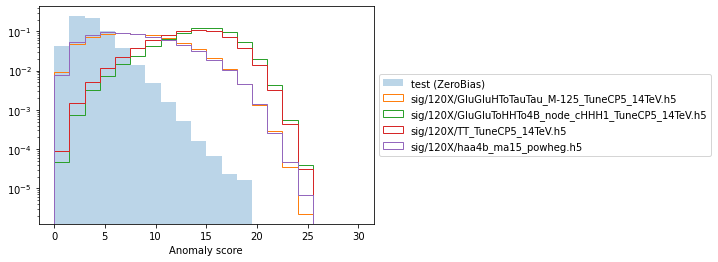

In [12]:
nbins = 20
rmin = 0
rmax = 30
plt.hist(X_test_predict, density = 1, bins = nbins, alpha = 0.3, label = 'test (ZeroBias)', range = (rmin, rmax), log = True)
#plt.hist(MC_ZB_loss[0], density = 1, bins = nbins, label = 'QCD', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
for i in range(3,7):
    plt.hist(MC_predict[i], density = 1, bins = nbins, label = MC_files[i], histtype = 'step', range = (rmin, rmax))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Anomaly score")
plt.show()

# Comparison between original and reconstructed inputs

In [ ]:
show_ZB = True
#show_ZB = False
n = 6
for i in range(1180,1190):
    fig, ax = plt.subplots(figsize = (17,17))
    if show_ZB == True:
        print('ZB test\nloss = ' + str(X_test_loss[i]))
    else:
        print(str(MC_files[n]) + '\nloss = ' + str(MC_loss[n][i]))
    ax = plt.subplot(3, 3, 1)
    if show_ZB == True:
        ax = sns.heatmap(X_test[i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(MC[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC[n][i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original')
    
    ax = plt.subplot(3, 3, 2)
    if show_ZB == True:
        ax = sns.heatmap(X_test_predict[i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(MC_predict[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC[n][i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed')
    
    ax = plt.subplot(3, 3, 3)
    if show_ZB == True:
        ax = sns.heatmap(np.absolute(X_test_predict[i,:,:,0] - X_test[i,:,:,0]).reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(np.absolute(MC_predict[n][i,:,:,0] - MC[n][i,:,:,0]).reshape(18, 14), vmin = 0, vmax = MC[n][i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('abs(original-reconstructed)')
    plt.show()

In [ ]:
#show_ZB = True
show_ZB = False
n = 3
for i in range(1180,1183):
    fig, ax = plt.subplots(figsize = (12,12))
    if show_ZB == True:
        print('ZB test\nloss = ' + str(X_test_loss[i]))
    else:
        print(str(MC_files[n]) + '\nloss = ' + str(MC_loss[n][i]))
    ax = plt.subplot(3, 3, 1)
    if show_ZB == True:
        ax = sns.heatmap(X_test[i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(MC_masked[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC_masked[n][i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original: No-bit channel')
    
    ax = plt.subplot(3, 3, 2)
    if show_ZB == True:
        ax = sns.heatmap(X_test[i,:,:,1].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,1].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(MC_masked[n][i,:,:,1].reshape(18, 14), vmin = 0, vmax = MC_masked[n][i,:,:,1].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original: EG channel')
    
    ax = plt.subplot(3, 3, 3)
    if show_ZB == True:
        ax = sns.heatmap(X_test[i,:,:,2].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,2].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(MC_masked[n][i,:,:,2].reshape(18, 14), vmin = 0, vmax = MC_masked[n][i,:,:,2].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original: Tau channel')
    
    ax = plt.subplot(3, 3, 4)
    if show_ZB == True:
        ax = sns.heatmap(X_test_predict[0][i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(MC_predict[n][0][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC_masked[n][i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed: No-bit channel')
    
    ax = plt.subplot(3, 3, 5)
    if show_ZB == True:
        ax = sns.heatmap(X_test_predict[1][i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,1].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(MC_predict[n][1][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC_masked[n][i,:,:,1].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed: EG channel')
    
    ax = plt.subplot(3, 3, 6)
    if show_ZB == True:
        ax = sns.heatmap(X_test_predict[2][i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,2].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(MC_predict[n][2][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC_masked[n][i,:,:,2].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed: Tau channel')
    
    plt.show()

# ROC plotting

### Assigning labels and arranging for ROC plotting

In [13]:
#Assign labels for various signals (y = 1) and backgrounds (y = 0)
Y_zb = np.zeros((X_test.shape[0], 1))
Y_mc = []
for i in range(len(MC)):
    Y_mc.append(np.ones((MC[i].shape[0], 1)))

#Concatenate datasets to make ROC curves, i.e. QCD/SingleNu/signals vs ZB

#True labels
Y_true = []
#Model scores
Y_model = []

for i in range(len(MC)):
    Y_true.append(np.concatenate((Y_mc[i], Y_zb)))
    Y_model.append(np.concatenate((MC_predict[i], X_test_predict)))

1
1
1


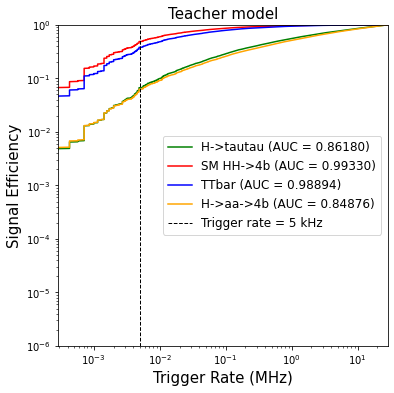

In [14]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_model = []
tpr_model = []
thresholds_model = []
roc_auc_model = []
for i in range(len(MC)):
    fpr_model.append(np.empty((Y_true[i].shape[0],1)))
    tpr_model.append(np.empty((Y_true[i].shape[0],1)))
    thresholds_model.append(np.empty((Y_true[i].shape[0],1)))
    roc_auc_model.append(np.empty((Y_true[i].shape[0],1)))
    fpr_model[i], tpr_model[i], thresholds_model[i] = roc_curve(Y_true[i], Y_model[i])
    roc_auc_model[i] = auc(fpr_model[i], tpr_model[i])
    fpr_model[i] *= 28.61
    if i == 0:
        print(1)
        #axes.plot(fpr_model[i], tpr_model[i], linestyle = '--', color = 'r', lw = 1, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_model[i]))
    if i == 1 or i == 2:
        print(1)
        #axes.plot(fpr_model[i], tpr_model[i], linestyle = ':', lw = 1, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_model[i]))
    if i == 3:
        #axes.plot(fpr_model[3], tpr_model[3], linestyle = '--', lw = 1, color = 'blue', label = 'SM H->2tau (AUC = %.5f)' % (roc_auc_model[3]))
        axes.plot(fpr_model[3], tpr_model[3], linestyle = '-', lw = 1.5, color = 'green', label = 'H->tautau (AUC = %.5f)' % (roc_auc_model[3]))
    if i == 4:
        #axes.plot(fpr_model[4], tpr_model[4], linestyle = '--', lw = 1, color = 'orange', label = 'SM HH->4b (AUC = %.5f)' % (roc_auc_model[4]))
        axes.plot(fpr_model[4], tpr_model[4], linestyle = '-', lw = 1.5, color = 'red', label = 'SM HH->4b (AUC = %.5f)' % (roc_auc_model[4]))
    if i == 5:
        #axes.plot(fpr_model[5], tpr_model[5], linestyle = '--', lw = 1, color = 'green', label = 'H->2LongLived->4b (AUC = %.5f)' % (roc_auc_model[5]))
        axes.plot(fpr_model[5], tpr_model[5], linestyle = '-', lw = 1.5, color = 'blue', label = 'TTbar (AUC = %.5f)' % (roc_auc_model[5]))
    if i == 6:
        #axes.plot(fpr_model[6], tpr_model[6], linestyle = '--', lw = 1, color = 'red', label = 'TTbar (AUC = %.5f)' % (roc_auc_model[6]))
        axes.plot(fpr_model[6], tpr_model[6], linestyle = '-', lw = 1.5, color = 'orange', label = 'H->aa->4b (AUC = %.5f)' % (roc_auc_model[6]))
axes.plot([0.005, 0.005], [0, 1], linestyle = '--', lw = 1, color = 'black', label = 'Trigger rate = 5 kHz')
axes.set_xlim([0.0002861, 28.61])
axes.set_ylim([0.000001, 1.0])
axes.set_xscale(value = "log")
axes.set_yscale(value = "log")
axes.set_xlabel('Trigger Rate (MHz)',size=15)
axes.set_ylabel('Signal Efficiency',size=15)
axes.set_title('Teacher model',size=15)
axes.legend(loc='center left', bbox_to_anchor = (0.3, 0.5),fontsize=12)
plt.show()